In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,brooklyn_zips,zip_list

from shapely import wkt

from IPython.display import display, Latex,Markdown
from tabulate import tabulate

In [2]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d14 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_14.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
finance = pd.read_csv('../../council_campaign_finance/data/located_data_subset_for_member_chapters.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
full_results_fourteen = full_results[full_results['district'] == 14]
full_results_fourteen['dpp20bs'] = full_results_fourteen['dpp20bs'] / 10
ps_full = full_results[full_results['candidate'] ==  'Pierina Ana Sanchez']
bw_full = full_results[full_results['candidate'] ==  'Brandon West']
#ps_full = ps_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio','mex21p', 'prican21p', 'domin21p', 'colomb21p']]
bw_full = bw_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]

d14 = make_edname(d14)
d14_eds = d14['ed_name'].unique().tolist()


max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

C:\Users\samtg\AppData\Local\Temp\ipykernel_30056\3046063932.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_fourteen['dpp20bs'] = full_results_fourteen['dpp20bs'] / 10


In [6]:
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

In [3]:
full_results_fourteen.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Pierina Ana Sanchez    3516.0
Yudelka Tapia          1922.0
Adolfo Abreu           1726.0
Haile Rivera            952.0
Fernando A. Aquino      887.0
Socrates S. Solano      168.0
overvote                157.0
Write-in                 30.0
217860.0                 27.0
220449.0                 12.0
217566.0                 11.0
218423.0                  9.0
221486.0                  8.0
217975.0                  2.0
Name: vote, dtype: float64

In [7]:
demo_occ = ps_full[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [8]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [11]:
test_cols = ['vote_share','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop'] + wp_cols

In [12]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,log_mhhi21,venez21p,chin21p,kor21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,-0.056185,-0.218335,0.148513,0.209943,0.070682,0.016764,0.076000,-0.015766,0.214998,...,0.090302,0.138742,0.008767,0.084613,0.067157,0.263330,0.032670,-0.016910,-0.031160,-0.146730
mex21p,0.267945,-0.248150,-0.606852,0.563129,0.199021,-0.217957,0.041895,0.053933,0.242967,-0.027637,...,0.229963,0.149840,-0.072503,0.240044,0.136787,0.372374,0.009026,0.002788,0.311131,-0.011728
w2conp,0.263330,-0.335013,-0.323163,0.378711,-0.064539,-0.401693,-0.085649,-0.017017,0.008891,-0.048644,...,0.090958,0.130430,0.088195,0.192733,0.127269,1.000000,-0.009289,0.040480,0.222558,-0.305434
w2foodp,0.226894,-0.351206,-0.365783,0.302984,0.244930,-0.427741,-0.017258,0.001735,0.034932,0.055284,...,0.408441,0.114321,-0.198474,-0.079206,0.011358,0.234625,0.114090,0.208313,0.278158,-0.086824
kor21p,0.214998,0.133445,0.140181,-0.309437,0.384876,0.490527,0.146019,-0.176086,0.030751,1.000000,...,0.049162,-0.176998,0.086732,-0.003362,-0.055695,-0.048644,-0.173658,0.027595,-0.058749,-0.173446
nha21p,0.209943,-0.048537,-0.000943,-0.262235,1.000000,0.191746,0.194177,0.108233,0.049233,0.384876,...,0.370054,0.207272,0.240101,0.087832,-0.041391,-0.064539,0.092710,0.145681,-0.103612,-0.097027
w2copp,0.191300,-0.128869,-0.270882,0.284151,0.065194,0.032732,-0.006077,-0.053705,-0.054404,-0.075216,...,0.137768,0.138869,0.236815,0.298785,-0.075766,0.337654,0.373315,-0.037843,-0.149431,0.016851
h21p,0.148513,-0.164998,-0.933689,1.000000,-0.262235,-0.468456,-0.143551,0.005102,0.095347,-0.309437,...,0.245501,0.108685,-0.154564,0.094123,0.062928,0.378711,-0.021365,0.031254,0.344255,-0.047094
pak21p,0.142573,-0.025412,0.007189,-0.071579,0.367534,0.143484,0.202257,0.374484,0.177896,-0.047829,...,-0.112677,-0.079538,-0.074387,-0.159044,0.251264,-0.064913,0.124099,-0.073511,0.200371,0.057615
w2pservep,0.138742,0.103149,-0.198256,0.108685,0.207272,-0.087610,-0.051946,0.218293,0.046310,-0.176998,...,0.032754,1.000000,-0.066740,0.182278,-0.185108,0.130430,-0.036924,-0.013665,-0.287152,-0.131545


In [4]:
top_three = full_results_fourteen[full_results_fourteen['candidate'].isin(['Pierina Ana Sanchez','Yudelka Tapia','Adolfo Abreu'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [5]:
def assign_color(row):
    if row['candidate'] == 'Pierina Ana Sanchez':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Yudelka Tapia':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [6]:
winners['candidate'].value_counts()

candidate
Pierina Ana Sanchez    81
Yudelka Tapia          11
Adolfo Abreu            3
Name: count, dtype: int64

In [7]:
winners['color'] = winners.apply(assign_color, axis=1)

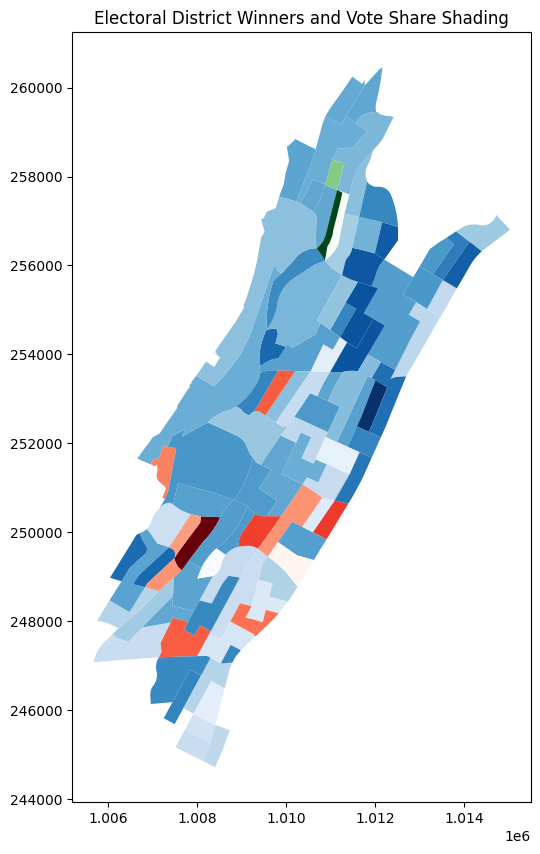

In [8]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [14]:
cor_cols = ['vote_share','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','mex21p', 'prican21p', 'domin21p', 'colomb21p'] + wp_cols
corr_df = ps_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [10]:
vote_corr

,vote_share
w2hsp,-0.377167
w2ffp,-0.318129
nhb21p,-0.218335
w2aep,-0.216338
w2htp,-0.163400
w2matp,-0.146730
domin21p,-0.133208
dpp20bs,-0.117394
w2cossp,-0.108662
w2scip,-0.084313


In [15]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [16]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['nhb21p','h21p']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['nhb21p','mex21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['nhb21p','mex21p','w2conp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(corr_df[['nhb21p','mex21p','w2conp','venez21p']])).fit()


In [17]:
summary_col([mod1,mod2,mod3,mod4],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII
const,71.1971***,36.4507***,34.8774***,34.4541***
,(20.1447),(2.8657),(2.9841),(3.0626)
nhb21p,-0.5209**,-0.0740,-0.0503,-0.0447
,(0.2352),(0.1057),(0.1055),(0.1062)
h21p,-0.3298,,,
,(0.2144),,,
mex21p,,0.2929*,0.2231,0.2221
,,(0.1722),(0.1753),(0.1759)
w2conp,,,0.1841*,0.1877*
,,,(0.1084),(0.1088)


In [36]:
cluster_cols = ['mex21p','w2hsp','w2conp','w2foodp','nhb21p','prican21p','w2ffp','mhhi21','w2aep']

In [37]:
df = corr_df[cluster_cols]
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

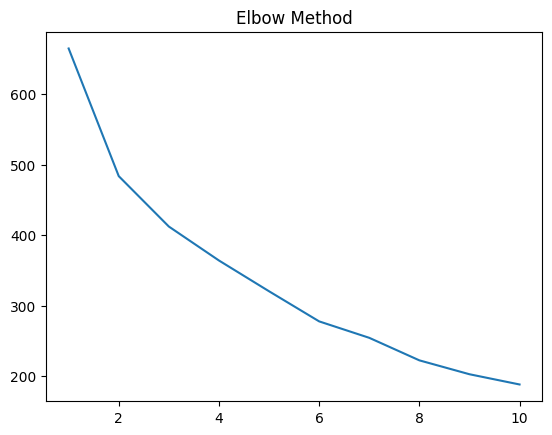

In [25]:
#elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [26]:
kmeans = KMeans(n_clusters=6, random_state=0)
corr_df['cluster'] = kmeans.fit_predict(scaled_df)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [27]:
corr_df.groupby('cluster')[cluster_cols].mean().round(2).reset_index()  

,cluster,mex21p,w2hsp,w2conp,w2foodp,nhb21p,prican21p,w2ffp
0,0,14.16,23.75,14.01,26.72,11.31,14.11,5.69
1,1,3.31,27.85,5.88,10.47,16.14,10.40,6.55
2,2,0.38,27.00,25.32,12.34,22.17,28.22,0.95
3,3,5.57,12.63,2.22,20.10,16.83,21.35,2.32
4,4,5.33,27.51,10.17,13.01,22.26,12.64,29.32
5,5,1.34,25.16,2.94,10.64,35.77,11.92,9.38


In [28]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=3)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
corr_df['pca1'] = pca_df[:,0]
corr_df['pca2'] = pca_df[:,1]
corr_df['pca3'] = pca_df[:,2]

In [40]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['pca1','pca2','pca3']])).fit()
summary_col([mod1],stars=True)

,vote_share
const,36.9456***
,(0.7261)
pca1,-1.9665***
,(0.4564)
pca2,-1.7946***
,(0.5549)
pca3,-0.2622
,(0.6336)
R-squared,0.2429
R-squared Adj.,0.2179


In [41]:
loadings = pd.DataFrame(pca.components_.T, index=cluster_cols, columns=['pca1', 'pca2', 'pca3'])
print(loadings)

               pca1      pca2      pca3
mex21p    -0.499989  0.083732  0.415563
w2hsp      0.093129  0.618887 -0.096947
w2conp    -0.389223 -0.249076  0.042016
w2foodp   -0.451510  0.207181  0.187821
nhb21p     0.473635 -0.190229 -0.039328
prican21p -0.267419 -0.182715 -0.477730
w2ffp      0.254518  0.082614  0.516592
mhhi21     0.147806 -0.237630  0.532626
w2aep      0.059277  0.610033 -0.023153


In [39]:
print(pca.explained_variance_ratio_)

[0.28121911 0.19026053 0.14595868]


EFA

In [6]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [68]:
corr_df = ps_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ElectDist', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
cor_cols = corr_df.drop(columns=['ElectDist','geometry','Precinct','ed_name','candidate','matched_name','member','geometry_x','geometry_y',
                                 'Shape_Area_x','Shape_Area_y','Shape_Area','vote', 'ElectDist_x', 'ElectDist_y','Shape_Leng',
                                 'Shape_Leng_y','Shape_Leng_x','winner', 'rank', 'ML3'
                                 ]).columns.tolist()
corr_df = corr_df[cor_cols]
corr_matrix = corr_df.corr()
corr_matrix = corr_matrix.sort_values('vote_share')
corr_matrix.dropna(subset=['vote_share'], inplace=True)
vote_corr = corr_matrix[['vote_share']]

In [49]:
vote_corr.sort_values('vote_share', ascending=False).sample(20)

,vote_share
wf2cm,-0.047394
wf2tw,-0.080330
wg2mgr,0.014373
con24p,0.087731
wm2fin,-0.093628
wps2sales,0.093913
wf2trans,-0.083072
wfp24,0.120298
colomb21p,0.022075
w2npp,-0.191445


In [10]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [29]:
predictors = [
    'log_mhhi21', 'cvap21bapp', 'nhb21p','nhw21p', 'h21p','nha21p',
    'perc_finance', 'mex21p','kor21p','femHHH_ratio',
    'w2cmp', 'w2admp', 'w2hsp', 'w2mgtp', 'w2bgp', 'w2lawp',
    'hh21op','bus_ratio','living_alone_ratio','w2matp','w2govp',
    'wfh_ratio','w2foodp','w2ffp','w2aep','w2npp',
    'drive_ratio','bike_ratio','train_ratio','black_fb_ratio',
    'w2tranp','prican21p','w2prodp'
]

X = corr_df[predictors]

In [69]:
y = corr_df['vote_share'].values
X = corr_df.drop(columns=['vote_share'])

In [70]:
lasso_pipe = make_pipeline(
    StandardScaler(),                 
    LassoCV(
        cv=5,
        random_state=0,
        n_alphas=100,
        max_iter=100_000,            
        tol=1e-4                     
    )
)

In [71]:
lasso_pipe.fit(X, y)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.778e-01, tolerance: 5.149e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=5, max_iter=100000, random_state=0))])

In [72]:
lasso = lasso_pipe.named_steps['lassocv']
coef = lasso.coef_
keep_mask = coef != 0
keep_raw = X.columns[keep_mask]

print("Chosen alpha:", lasso.alpha_)
print("Selected demographics:", keep_raw.tolist())

Chosen alpha: 1.2997450890457751
Selected demographics: ['mex21p', 'perc_finance', 'wm2hs', 'wm2cons', 'wf2ff', 'wm2con', 'wse2conmaint', 'w2hsp', 'w2ffp', 'w2foodp', 'w2sep']


In [73]:
X_screened = corr_df[keep_raw]

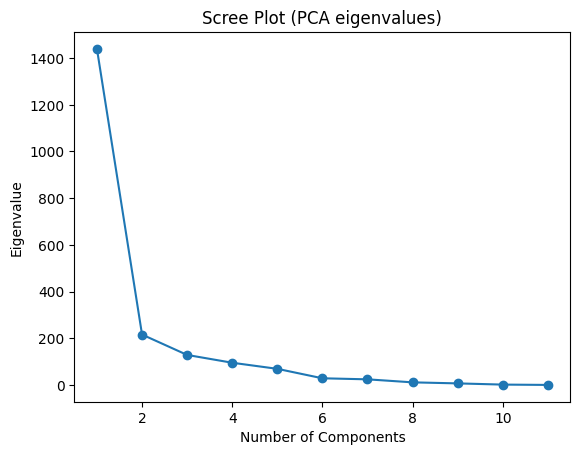

In [74]:
pca = PCA()
pca.fit(X_screened)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [75]:
n_factors = 4
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [76]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=corr_df.index
)

In [ ]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

In [78]:
keep_raw = X_screened.columns.tolist()

n_factors = 4
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X_screened)

loadings = pd.DataFrame(
    fa.components_.T,          
    index=keep_raw,            
    columns=[f'Factor{i+1}' for i in range(n_factors)]
)
print("Factor Loadings:\n", loadings)


Factor Loadings:
                 Factor1    Factor2   Factor3   Factor4
mex21p         3.918289   1.653741 -1.074035  0.024487
perc_finance  -0.029189   0.009588 -0.239248  0.008876
wm2hs          0.505419   0.780519  9.922928 -4.262329
wm2cons       23.304973 -12.609793  0.423181  0.687894
wf2ff         -0.749625   0.329826  7.884934  7.998634
wm2con        22.703749 -10.813247  2.647145 -2.773309
wse2conmaint   0.398274   0.502421  0.147907  0.017288
w2hsp         -0.363702   1.835173  4.590506 -3.279377
w2ffp         -0.651200  -0.465482  3.489107  2.601825
w2foodp        6.264452   6.728116 -0.305181  0.232618
w2sep         -0.001779   0.323264 -0.100261 -0.112419


In [79]:
y = corr_df.loc[fa_df.index, 'vote_share']
X_inf = sm.add_constant(fa_df)  
ols_model = sm.OLS(y, X_inf).fit()


print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.1985
Date:                Fri, 23 May 2025   Prob (F-statistic):              0.939
Time:                        15:00:58   Log-Likelihood:                -331.46
No. Observations:                  95   AIC:                             672.9
Df Residuals:                      90   BIC:                             685.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.9456      0.835     44.221      0.0

In [17]:
Y = corr_df['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.061
Date:                Fri, 23 May 2025   Prob (F-statistic):            0.00451
Time:                        13:25:39   Log-Likelihood:                -324.00
No. Observations:                  95   AIC:                             658.0
Df Residuals:                      90   BIC:                             670.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.9456      0.772     47.836      0.0

In [18]:
y = corr_df['vote_share'].values  
F = factor_scores  

In [20]:
lasso = LassoCV(
    cv=5,                
    random_state=0,
    n_alphas=100,        
    max_iter=10_000
)
lasso.fit(F, y)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [21]:
keep_idx = np.where(np.abs(lasso.coef_) > 1e-6)[0]
print("LASSO kept factors:", keep_idx)

LASSO kept factors: [0 1 2 3]


In [22]:
F_reduced = F[:, keep_idx]
F_reduced = sm.add_constant(F_reduced)